In [1]:
import copy
import os
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from torch import nn
from sklearn.metrics import accuracy_score

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
from cassava.utils import *
from cassava.transforms import get_train_transforms, get_test_transforms

In [4]:
from pl_bolts.models.self_supervised import MocoV2

In [5]:
from pytorch_lightning import Trainer
from argparse import Namespace

In [6]:
from cassava.models.model import LeafDoctorModel

# Prepare data

In [7]:
train_images_torch = context.catalog.load('train_images_torch')

2020-12-10 16:12:54,456 - kedro.io.data_catalog - INFO - Loading data from `train_images_torch` (ImageFolderDataSet)...


In [8]:
train_labels = context.catalog.load('train_labels')

2020-12-10 16:12:54,502 - kedro.io.data_catalog - INFO - Loading data from `train_labels` (CSVDataSet)...


In [9]:
parameters = context.catalog.load('parameters')

2020-12-10 16:12:54,531 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [10]:
parameters

{'seed': 42,
 'cv_splits': 3,
 'cv_models_dir': 'data/06_models/cv_folds',
 'validation_size': 0.15,
 'data_loader_workers': 4,
 'classifier': {'gpus': -1,
  'batch_size': 10,
  'max_epochs': 100,
  'max_steps': 0,
  'auto_lr_find': 0,
  'lr': 0.001,
  'weight_decay': 0.0001,
  'early_stop_patience': 4,
  'accumulate_grad_batches': 4,
  'reduce_lr_on_pleteau_patience': 2,
  'save_top_k_checkpoints': 1,
  'checkpoints_dir': 'data/06_models/classifier/checkpoints'},
 'byol': {'gpus': -1,
  'batch_size': 10,
  'max_epochs': 10,
  'max_steps': 0,
  'auto_lr_find': 1,
  'weight_decay': 0.0001,
  'accumulate_grad_batches': 4,
  'save_top_k_checkpoints': 1,
  'checkpoints_dir': 'data/06_models/byol/checkpoints'}}

In [11]:
res = context.pipelines['train'].nodes[0].run({'train_labels': train_labels, 'parameters': parameters})
train_indices = np.array(res['train_indices'])
val_indices = np.array(res['val_indices'])

2020-12-10 16:12:54,547 - kedro.pipeline.node - INFO - Running node: split: split_data([parameters,train_labels]) -> [train_indices,val_indices]


In [12]:
train_indices.shape, val_indices.shape

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((18187,), (3210,))

In [13]:
unnorm = Unnormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [14]:
raw_transforms = A.Compose([
        A.ToFloat(max_value=1.0),
        A.Resize(256, 256),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
])

def get_train_transforms():
    return A.Compose([
        #A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=1),
        A.ToFloat(max_value=1.0),
        A.RandomResizedCrop(256, 256, scale=(0.3, 0.9)),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])


def get_test_transforms():
    return A.Compose([
        A.ToFloat(max_value=1.0),
        A.CenterCrop(400, 400),
        A.Resize(256, 256),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

In [16]:
train_transform, val_transform = get_train_transforms(), get_test_transforms()

train_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=train_indices),
                                      transform=train_transform)

val_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=val_indices),
                                transform=val_transform)

train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=parameters['classifier']['batch_size'],
                                                num_workers=parameters['data_loader_workers'],
                                                shuffle=True)

val_data_loader = torch.utils.data.DataLoader(val_dataset, num_workers=parameters['data_loader_workers'], batch_size=parameters['classifier']['batch_size'])

In [17]:
raw_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=list(range(len(train_images_torch)))), transform=raw_transforms)
augmented_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=list(range(len(train_images_torch)))), transform=get_train_transforms())
test_aug_dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=list(range(len(train_images_torch)))), transform=get_test_transforms())

3


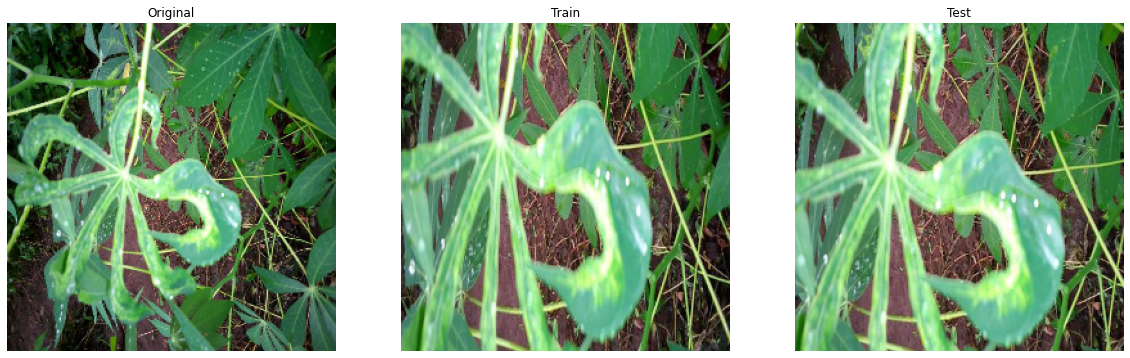

In [18]:
idx = np.random.choice(range(len(train_images_torch)))
raw_image, label = raw_dataset[idx]
aug_image, _ = augmented_dataset[idx]
test_aug_image, _ = test_aug_dataset[idx]

print(label)
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plot_image(unnorm(raw_image))
plt.title('Original')
plt.subplot(1, 3, 2)
plot_image(unnorm(aug_image))
plt.title('Train')
plt.subplot(1, 3, 3)
plot_image(unnorm(test_aug_image))
plt.title('Test')
plt.show()

In [19]:
raw_image.shape, aug_image.shape, test_aug_image.shape

(torch.Size([3, 256, 256]),
 torch.Size([3, 256, 256]),
 torch.Size([3, 256, 256]))

# Define model

In [20]:
# !pip install kornia

In [21]:
#!pip install pytorch-lightning-bolts

In [22]:
import random
from typing import Callable, Tuple

from kornia import augmentation as aug
from kornia import filters
from kornia.geometry import transform as tf
import torch
from torch import nn, Tensor


class RandomApply(nn.Module):
    def __init__(self, fn: Callable, p: float):
        super().__init__()
        self.fn = fn
        self.p = p

    def forward(self, x: Tensor) -> Tensor:
        return x if random.random() > self.p else self.fn(x)


def default_augmentation(image_size: Tuple[int, int] = (224, 224)) -> nn.Module:
    return nn.Sequential(
        tf.Resize(size=image_size),
        RandomApply(aug.ColorJitter(0.8, 0.8, 0.8, 0.2), p=0.8),
        aug.RandomGrayscale(p=0.2),
        aug.RandomHorizontalFlip(),
        RandomApply(filters.GaussianBlur2d((3, 3), (1.5, 1.5)), p=0.1),
        aug.RandomResizedCrop(size=image_size),
        aug.Normalize(
            mean=torch.tensor([0.485, 0.456, 0.406]),
            std=torch.tensor([0.229, 0.224, 0.225]),
        ),
    )

from typing import Union


def mlp(dim: int, projection_size: int = 256, hidden_size: int = 4096) -> nn.Module:
    return nn.Sequential(
        nn.Linear(dim, hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_size, projection_size),
    )


class EncoderWrapper(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        projection_size: int = 256,
        hidden_size: int = 4096,
        layer: Union[str, int] = -2,
    ):
        super().__init__()
        self.model = model
        self.projection_size = projection_size
        self.hidden_size = hidden_size
        self.layer = layer

        self._projector = None
        self._projector_dim = None
        self._encoded = torch.empty(0)
        self._register_hook()

    @property
    def projector(self):
        if self._projector is None:
            self._projector = mlp(
                self._projector_dim, self.projection_size, self.hidden_size
            )
        return self._projector

    def _hook(self, _, __, output):
        output = output.flatten(start_dim=1)
        if self._projector_dim is None:
            self._projector_dim = output.shape[-1]
        self._encoded = self.projector(output)

    def _register_hook(self):
        if isinstance(self.layer, str):
            layer = dict([*self.model.named_modules()])[self.layer]
        else:
            children = list(self.model.children())
#             if len(children) == 1:
#                 children = children[0]
            layer = children[self.layer]

        layer.register_forward_hook(self._hook)

    def forward(self, x: Tensor) -> Tensor:
        _ = self.model(x)
        return self._encoded


In [23]:
from copy import deepcopy
from itertools import chain
from typing import Dict, List

import pytorch_lightning as pl
from torch import optim
import torch.nn.functional as f


def normalized_mse(x: Tensor, y: Tensor) -> Tensor:
    x = f.normalize(x, dim=-1)
    y = f.normalize(y, dim=-1)
    return 2 - 2 * (x * y).sum(dim=-1)


class BYOL(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        image_size: Tuple[int, int] = (128, 128),
        hidden_layer: Union[str, int] = -2,
        projection_size: int = 256,
        hidden_size: int = 4096,
        augment_fn: Callable = None,
        beta: float = 0.99,
        **hparams,
    ):
        super().__init__()
        self.augment = default_augmentation(image_size) if augment_fn is None else augment_fn
        self.beta = beta
        self.encoder = EncoderWrapper(
            model, projection_size, hidden_size, layer=hidden_layer
        )
        self.predictor = nn.Linear(projection_size, projection_size, hidden_size)
        self.hparams = hparams
        self._target = None

        self.encoder(torch.zeros(2, 3, *image_size))

    def forward(self, x: Tensor) -> Tensor:
        return self.predictor(self.encoder(x))

    @property
    def target(self):
        if self._target is None:
            self._target = deepcopy(self.encoder)
        return self._target

    def update_target(self):
        for p, pt in zip(self.encoder.parameters(), self.target.parameters()):
            pt.data = self.beta * pt.data + (1 - self.beta) * p.data

    # --- Methods required for PyTorch Lightning only! ---

    def configure_optimizers(self):
        optimizer = getattr(optim, self.hparams.get("optimizer", "Adam"))
        lr = self.hparams.get("lr", 1e-4)
        weight_decay = self.hparams.get("weight_decay", 1e-6)
        return optimizer(self.parameters(), lr=lr, weight_decay=weight_decay)

    def training_step(self, batch, *_) -> Dict[str, Union[Tensor, Dict]]:
        x = batch[0]
        with torch.no_grad():
            x1, x2 = self.augment(x), self.augment(x)

        pred1, pred2 = self.forward(x1), self.forward(x2)
        with torch.no_grad():
            targ1, targ2 = self.target(x1), self.target(x2)
        loss = torch.mean(normalized_mse(pred1, targ2) + normalized_mse(pred2, targ1))

        self.log("train_loss", loss.item())
        return {"loss": loss}

    @torch.no_grad()
    def validation_step(self, batch, *_) -> Dict[str, Union[Tensor, Dict]]:
        x = batch[0]
        x1, x2 = self.augment(x), self.augment(x)
        pred1, pred2 = self.forward(x1), self.forward(x2)
        targ1, targ2 = self.target(x1), self.target(x2)
        loss = torch.mean(normalized_mse(pred1, targ2) + normalized_mse(pred2, targ1))

        return {"loss": loss}

    @torch.no_grad()
    def validation_epoch_end(self, outputs: List[Dict]) -> Dict:
        val_loss = sum(x["loss"] for x in outputs) / len(outputs)
        self.log("val_loss", val_loss.item())

# Train

In [24]:
# !pip install byol-pytorch

In [25]:
# import pytorch_lightning as pl
# import torch
# from byol_pytorch import BYOL
# from torchvision import models

# class BYOLModel(pl.LightningModule):
#     def __init__(self, hparams = None):
#         super().__init__()
#         self.hparams = hparams or Namespace()

#         self.learner = BYOL(
#             models.resnet18(pretrained=True),
#             image_size = 256,
#             hidden_layer = 'avgpool',
#         )


#     def forward(self, x):
#         return self.learner(x)
    
#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.learner.parameters(), lr=3e-4)

#         return {
#             'optimizer': optimizer,
#         }

#     def training_step(self, batch, batch_idx):
#         images, labels = batch
#         loss = self.learner(images)
#         if torch.isnan(loss):
#             print('LOSS IS NAN')
#             raise Exception("JESUS CHRIST NAN LOSS")
#         self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
#         return loss
    
#     def on_before_zero_grad(self, opt):
#         self.learner.update_moving_average()

#     def validation_step(self, batch, batch_idx):
#         images, labels = batch
#         loss = self.learner(images)
#         self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
#         return loss

In [26]:
#parameters['auto_lr_find'] = True
# parameters['lr'] = 0.1
hparams = Namespace(**parameters)

In [27]:
model = LeafDoctorModel(hparams)

In [28]:
byol = BYOL(model.trunk, image_size=(256, 256))

In [29]:
trainer = Trainer.from_argparse_args(
    hparams,
    reload_dataloaders_every_epoch = True,
#     gradient_clip_val = 0.5,
    accumulate_grad_batches = 4,
    terminate_on_nan = True,
)

GPU available: True, used: False


2020-12-10 16:13:52,648 - lightning - INFO - GPU available: True, used: False


TPU available: False, using: 0 TPU cores


2020-12-10 16:13:52,649 - lightning - INFO - TPU available: False, using: 0 TPU cores


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


In [30]:
# lr_finder = trainer.tuner.lr_find(model,
#                                   train_dataloader=train_data_loader,
#                                   val_dataloaders=[val_data_loader])
# plt.figure()
# plt.title('LR finder results')
# lr_finder.plot(suggest=True)
# plt.show()
# new_lr = lr_finder.suggestion()
# model.hparams.lr = new_lr
# new_lr

In [31]:
trainer.fit(byol, train_data_loader, val_data_loader)


  | Name      | Type           | Params
---------------------------------------------
0 | augment   | Sequential     | 0     
1 | encoder   | EncoderWrapper | 10.3 M
2 | predictor | Linear         | 65.8 K


2020-12-10 16:13:54,096 - lightning - INFO - 
  | Name      | Type           | Params
---------------------------------------------
0 | augment   | Sequential     | 0     
1 | encoder   | EncoderWrapper | 10.3 M
2 | predictor | Linear         | 65.8 K


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [ ]:
model = model.eval()

In [ ]:
raw_image.shape

In [ ]:
model.cuda()

In [ ]:
(raw_image.unsqueeze(0).to('cuda'))

# Supervised training and accuracy check

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
state_dict = byol.encoder.model.state_dict()
model = LeafDoctorModel(hparams)
model.trunk.load_state_dict(state_dict)

In [ ]:
early_stopping = EarlyStopping('val_acc',
                                   patience=parameters['early_stop_patience'],
                                   verbose=True,
                                   )

hparams = Namespace(**parameters)

trainer = Trainer.from_argparse_args(
    hparams,
    reload_dataloaders_every_epoch = True,
    callbacks=[early_stopping],
)

In [ ]:
trainer.fit(model, train_data_loader, val_data_loader)

In [ ]:
hparams

In [ ]:
parameters['classifier'] = parameters

In [ ]:
from cassava.pipelines.train_model.nodes import score_model

In [ ]:
model = model.cuda()

In [ ]:
scores, _ = score_model(model, train_images_torch, val_indices, parameters)

scores